Laboratorium 6 - Teoria Śladów
===
Sprawozdanie - Jakub Darul

Link do repozytorium :
https://bitbucket.org/Ja0Dar/concurrency_lab


 Polecenie:
 ---
Napisz program w dowolnym języku, który:

1. Wyznacza relację zależności D (2 p.)
2. Wyznacza postać normalną Foaty FNF([w]) śladu [w] (3 p.)
3. Rysuje graf zależności w postaci minimalnej dla słowa w (3 p.)
4. Wyznacza postać normalną Foaty na podstawie grafu (2 p.)

In [1]:
# importy
from itertools import product
import networkx as nx
from functional import seq #pyfunctional
import matplotlib.pyplot as plt

Dane wejściowe : 
--
    
Alfabet akcji *A*, Relacja niezależności *I*, Słowo *w*

In [2]:
a='a'
b='b'
c='c'
d='d'
e='e'
f='f'

A = {a, b, c, d}
I = {(a, d), (d, a), (b, c), (c, b)} # niezależne 
w = "baadcb"

1. Wyznacza relację zależności D (2 p.)
===

Relacja zależności to dopełnienie relacji niezależności, więc :

*D = A x A - I*

In [3]:
def depenency_relation(I,A):
    return set(product(A,A))-I

In [4]:
depenency_relation(I,A)

{('a', 'a'),
 ('a', 'b'),
 ('a', 'c'),
 ('b', 'a'),
 ('b', 'b'),
 ('b', 'd'),
 ('c', 'a'),
 ('c', 'c'),
 ('c', 'd'),
 ('d', 'b'),
 ('d', 'c'),
 ('d', 'd')}

2. Wyznacza postać normalną Foaty FNF([w]) śladu [w]
===

Zaimplementowałem algorytm ze stosami zaproponowany w  *Partial commutation and traces*

In [5]:
def empty(x):
    return len(x)==0

def foat_normal_form(word,I):
    
    stacks ={l:[] for l in word}
    for l in reversed(word):
        for stack_l, stack in stacks.items():
            if l==stack_l:
                stack.append(l)
            elif (stack_l,l) not in I:
                stack.append(None)

    fnf=[]
    subword=[]
    
    def stacks_empty():
        return seq(stacks).map(lambda l: 0 if empty(stacks[l]) or stacks[l][-1] is None else 1).sum() == 0
    
    while not stacks_empty():

        for stack_l, stack in stacks.items():
            if not empty(stack) and stack[-1] is not None:
                subword.append(stack.pop())
        
        for l in subword:
            for stack_l,stack in stacks.items():
                if  stack_l != l and not empty(stack) and (l,stack_l) not in I and stack[-1] is None:
                    stack.pop()
        fnf.append("".join(sorted(subword)))    
        subword=[]       
    return seq(fnf).map(lambda x: "({})".format(x)).make_string("")
    
            

In [6]:
foat_normal_form(w,I)

'(b)(ad)(a)(bc)'

3. Rysuje graf zależności w postaci minimalnej dla słowa w (3 p.)
===
Tworzę minimalny graf zależności budując krawędzie między i-tą akcją i wszystkimi na prawo od niej, które są od niej zależne,a następnie usuwam nadmiarowe krawędzie

In [7]:
def build_dependency_graph(word,I):
    G=nx.DiGraph()
    add_all_dependence_edges(G,word,I)        
    remove_redundant_dependencies(G)
    node_labels= build_labels(word)
  
    G2=nx.relabel_nodes(G,node_labels)
    return G2


def add_all_dependence_edges(G,word,I):
    for node,label in enumerate(word[:-1]):
        for node2,label2 in list(enumerate(word))[node+1:]:
            if not (label,label2) in I:
                G.add_edge(node,node2)

                
def remove_redundant_dependencies(G):
    def multiple_paths_present(paths):
        return len(paths)>1
    
    for start_node in range(len(G.nodes)-1):
        for end_node in range(start_node+1,len(G.nodes)):
            paths= list(nx.all_simple_paths(G,start_node,end_node))
            if multiple_paths_present(paths):
                direct_paths = list(filter(lambda x: len(x)==2,paths))
                if not empty(direct_paths):
                    n1,n2= direct_paths[0]
                    G.remove_edge(n1,n2)
                        
def build_labels(word):
    node_labels={}
    label_counter={}
    for l in word:
        label_counter[l]=0

    for i,label in enumerate(word):
        node_labels[i]="{}{}".format(label,label_counter[label])
        label_counter[label]+=1
    return node_labels

In [8]:
def draw_dependecny_graph(G):
    nx.draw(G,arrows=True,with_labels=True,pos=nx.shell_layout(G))
    plt.show()

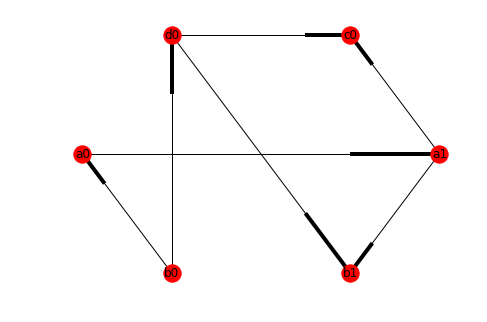

In [9]:
G2= build_dependency_graph(w,I)
draw_dependecny_graph(G2)

4. Wyznacza postać normalną Foaty na podstawie grafu (2 p.)
===
Do tego stosuję sortowanie topologiczne i algorytm zaimplementowany w podp. 2

In [10]:
def foat_from_graph(G,I):
    word=list(nx.topological_sort(G))
    return foat_normal_form(seq(word).map(lambda x: x[:-1]).make_string(""),I)

In [11]:
foat_from_graph(G2,I)

'(b)(ad)(a)(bc)'

FNF z grafu wyszła taka sama jak ze słowa, co wskazuje na poprawną implementację budowania grafu.

Testy
====

Relacja niezależności jest symetryczna, więc aby nie pisać za dużo generuję ją z "minimalnej" relacji.

In [13]:

A1,I1,w1 = {a,b,c,d,e,f}, {(a, d),(b, e),(c, d),(c, f)},"acdcfbbe"
A2,I2,w2 = {a,b,c,d,e},{(a,d),(b,d),(a,c),(e,b)},"acebdac"

def add_symetry(tuples:set):
    new_tuples=set()
    for a,b in tuples:
        new_tuples.add((b,a))
    tuples.update(new_tuples)
        

def present(A,I,word):
    print("word : {}".format(word))
    add_symetry(I)
    
    print("I:",I,"\n")
    print("D: ",depenency_relation(I,A))
    
    print("\n FNF na podstawie słowa {} : {}".format(word,foat_normal_form(word,I)))
    G= build_dependency_graph(word,I)
    draw_dependecny_graph(G)
    
    print("\n FNF na podstawie Grafu : ",foat_from_graph(G,I))

Dane testowe 2:
---

word : acdcfbbe
I: {('f', 'c'), ('c', 'd'), ('e', 'b'), ('d', 'a'), ('c', 'f'), ('b', 'e'), ('d', 'c'), ('a', 'd')} 

D:  {('e', 'a'), ('d', 'd'), ('b', 'f'), ('a', 'a'), ('b', 'c'), ('b', 'b'), ('c', 'a'), ('a', 'f'), ('f', 'a'), ('a', 'b'), ('e', 'e'), ('c', 'b'), ('e', 'c'), ('d', 'e'), ('b', 'a'), ('e', 'f'), ('c', 'c'), ('f', 'e'), ('e', 'd'), ('a', 'c'), ('a', 'e'), ('d', 'b'), ('c', 'e'), ('d', 'f'), ('b', 'd'), ('f', 'b'), ('f', 'd'), ('f', 'f')}

 FNF na podstawie słowa acdcfbbe : (ad)(cf)(c)(be)(b)


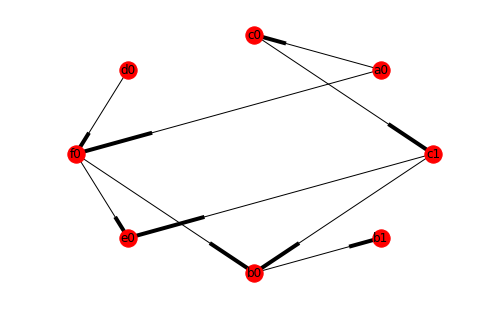


 FNF na podstawie Grafu :  (ad)(cf)(c)(be)(b)


In [16]:
present(A1,I1,w1)

Dane testowe 3
---

word : acebdac
I: {('d', 'b'), ('e', 'b'), ('d', 'a'), ('c', 'a'), ('b', 'd'), ('b', 'e'), ('a', 'd'), ('a', 'c')} 

D:  {('e', 'a'), ('c', 'd'), ('a', 'e'), ('d', 'd'), ('e', 'e'), ('a', 'a'), ('b', 'c'), ('c', 'b'), ('e', 'c'), ('c', 'e'), ('b', 'b'), ('d', 'e'), ('b', 'a'), ('e', 'd'), ('d', 'c'), ('c', 'c'), ('a', 'b')}

 FNF na podstawie słowa acebdac : (ac)(be)(ad)(c)


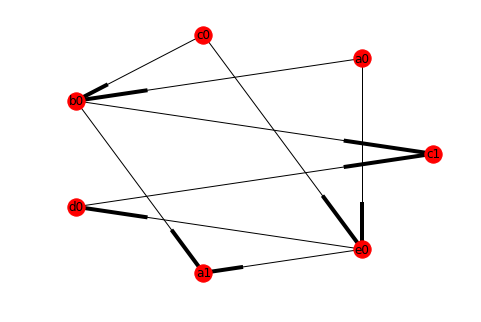


 FNF na podstawie Grafu :  (ac)(be)(ad)(c)


In [17]:
present(A2,I2,w2)